## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("_data/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("_data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("_data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

/var/folders/78/5qnmg9f96cg9pft1yg81flk80000gn/T/ipykernel_27094/2131385477.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

/var/folders/78/5qnmg9f96cg9pft1yg81flk80000gn/T/ipykernel_27094/3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations to SAT score

In [9]:
combined_corr = combined.corr()["sat_score"]

combined_corr

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64

## Plot correlations of survey results to SAT score

<AxesSubplot:>

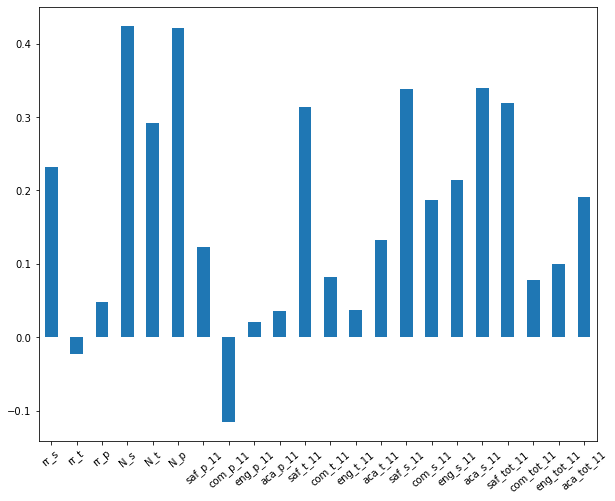

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

# Remove since it is an ID field and not useful otherwise
survey_fields.remove("DBN")

# Plot SAT score correlations to survey data only
combined.corr()["sat_score"][survey_fields].plot.bar(rot=40, figsize=(10,8))

## Scatterplot of Student Safety Perceptions vs. SAT Scores

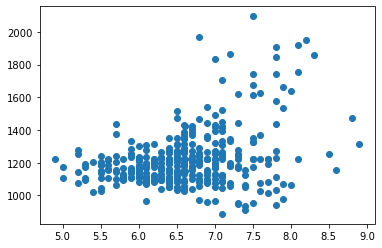

In [11]:
plt.scatter(x=combined["saf_s_11"], y=combined["sat_score"])
plt.show()

The scatterplot above confirms that there is some correlation between student safety perceptions and SAT scores.  Generally, high SAT scores seem to have higher safety perception and low SAT scores seem to have lower safety perception.

## Bar Graph of Race Percentage to SAT Score Correlations

<AxesSubplot:>

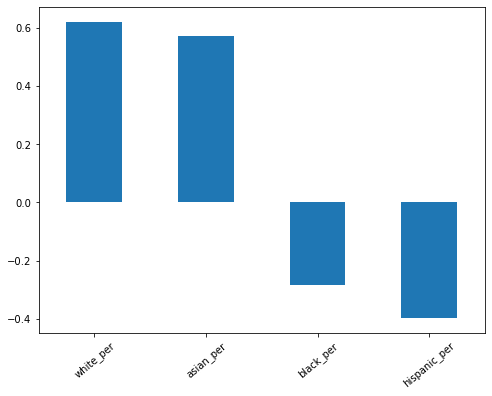

In [12]:
race_pct = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_pct].plot.bar(rot=40, figsize=(8,6))

It can be easily seen from the bar graph above that schools with higher white and asian populations have higher SAT scores.  On the other hand, schools with higher black and hispanic populations have lower SAT scores.

## Scatterplot of Hispanic Percentage and SAT Scores

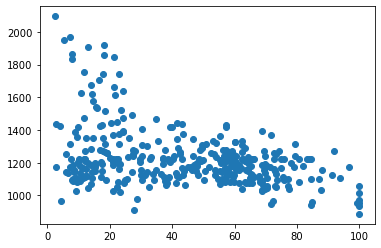

In [13]:
plt.scatter(x=combined["hispanic_per"], y=combined["sat_score"])
plt.show()

We can see from the above scatteplot that there are schools with low hispanic populations and low SAT scores.  So just because a school has more white, asian, or black populations does not necessarily mean that their SAT scores are higher.  However, most of the schools with more than half of their population being hispanic likely means that thei SAT scores are lower.

## Schools with Hispanic Population > 95%

In [14]:
combined[["SCHOOL NAME", "hispanic_per"]][combined["hispanic_per"] > 95]

,SCHOOL NAME,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0


The schools with greater than 95% hispanic population appear to be primarily geared towards recent immigrants to the US.  There are a lot of English learners, which is why the SAT scores are 1000 and below (at the right-most of the scatterplot).

## Schools with Hispanic Population < 10% and SAT Score > 1800

In [15]:
combined[["SCHOOL NAME", "hispanic_per"]][(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]

,SCHOOL NAME,hispanic_per
37,STUYVESANT HIGH SCHOOL,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3


## Gender vs. SAT Score

<AxesSubplot:>

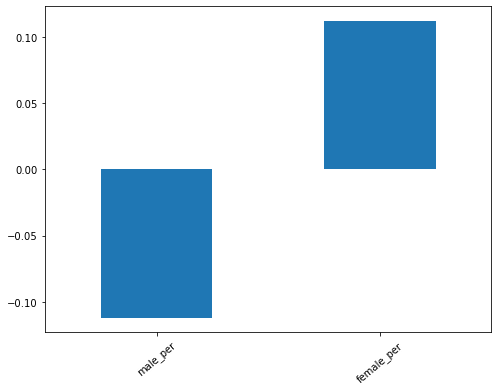

In [16]:
race_pct = ["male_per", "female_per"]
combined.corr()["sat_score"][race_pct].plot.bar(rot=40, figsize=(8,6))

Although the correlations are not very strong, directionally it appears that schools with higher female population perform better on the SAT in general than schools with more male population.

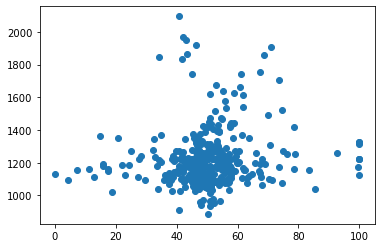

In [17]:
plt.scatter(x=combined["female_per"], y=combined["sat_score"])
plt.show()

There are several all-girls schools that seem to have higher SAT scores than the several schools that are all (or mostly) male.  Also, there are a handful of schools with around only 40% female population that have SAT scores around 1800 or above.

In [18]:
combined[["SCHOOL NAME", "female_per"]][(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]

,SCHOOL NAME,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5
60,BEACON HIGH SCHOOL,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,71.1


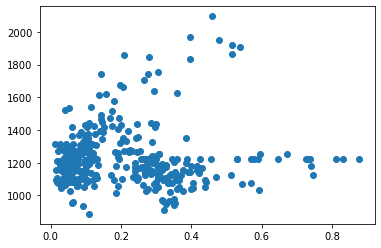

In [19]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

plt.scatter(x=combined["ap_per"], y=combined["sat_score"])
plt.show()

Though not a strong correlation, there does appear to be a relationship between the percentage of students in a school who took an AP exam and their average SAT scores.